# Read Results


In [1]:
import pickle

with open("cache/dpf_mvsa_single_results.pkl", "rb") as f:
    results = pickle.load(f)

# RETRIEVE  Varibles from results
train_probs_text   = results["train_probs_text"]
train_probs_image  = results["train_probs_image"]

val_probs_text     = results["val_probs_text"]
val_probs_image    = results["val_probs_image"]

test_probs_text    = results["test_probs_text"]
test_probs_image   = results["test_probs_image"]

y_train_int = results["y_train_int"]
y_val_int   = results["y_val_int"]
y_test_int  = results["y_test_int"]

beta  = results["beta"]
topk  = results["topk"]
delta = results["delta"]

In [2]:
import numpy as np
import xgboost as xgb
import time
from sklearn.ensemble import ExtraTreesClassifier
def dynamic_weight_topk_adaptive(prob1, prob2, beta=0.1, topk=2, delta=1e-4):
    """
    Calculate dynamic weights for two modalities using Top-k Approximate Rényi-2 entropy
    with adaptive epsilon regularization for numerical stability.

    Args:
        prob1 (ndarray): Text modality predicted probabilities, shape (n_samples, n_classes)
        prob2 (ndarray): Image modality predicted probabilities, shape (n_samples, n_classes)
        beta (float): Temperature scaling factor.
        topk (int): Number of top probabilities to consider for entropy approximation.
        delta (float): Scaling factor for adaptive epsilon, relative to maximum squared probability.

    Returns:
        weights (ndarray): Normalized modality weights, shape (n_samples, 2)
    """
    # Select Top-k largest probabilities
    topk_prob1 = np.sort(prob1, axis=1)[:, -topk:]  # shape: (n_samples, topk)
    topk_prob2 = np.sort(prob2, axis=1)[:, -topk:]

    # Compute adaptive epsilon based on maximum p² in Top-k
    max_p2_text = np.max(topk_prob1**2, axis=1, keepdims=True)  # shape: (n_samples, 1)
    max_p2_image = np.max(topk_prob2**2, axis=1, keepdims=True)

    adaptive_eps_text = delta * max_p2_text  # epsilon for text modality
    adaptive_eps_image = delta * max_p2_image  # epsilon for image modality

    # Compute energy (negative log collision probability)
    energy_text = -np.log(np.sum(topk_prob1**2, axis=1, keepdims=True) + adaptive_eps_text).flatten()
    energy_image = -np.log(np.sum(topk_prob2**2, axis=1, keepdims=True) + adaptive_eps_image).flatten()

    # Compute normalized weights via Gibbs-style softmax
    energies = np.vstack([energy_text, energy_image]).T  # shape: (n_samples, 2)
    weights = np.exp(-beta * energies)
    weights /= np.sum(weights, axis=1, keepdims=True)

    return weights

def enhanced_dynamic_fusion_topk_adaptive(probs_text, probs_image, beta=0.1, topk=2, delta=1e-4):
    """
    Perform enhanced fusion by dynamically weighting two modalities and concatenating
    their weighted outputs, preserving modality-specific information.

    Args:
        probs_text (ndarray): Text modality predicted probabilities, shape (n_samples, n_classes)
        probs_image (ndarray): Image modality predicted probabilities, shape (n_samples, n_classes)
        beta (float): Temperature scaling factor.
        topk (int): Top-k approximation size.
        delta (float): Adaptive epsilon scaling factor.

    Returns:
        enhanced_fused_probs (ndarray): Concatenated weighted probability vectors, shape (n_samples, 2*n_classes)
    """
    weights = dynamic_weight_topk_adaptive(probs_text, probs_image, beta, topk, delta)
    fused_text = weights[:, 0:1] * probs_text  # weight applied to text probabilities
    fused_image = weights[:, 1:2] * probs_image  # weight applied to image probabilities
    enhanced_fused_probs = np.concatenate([fused_text, fused_image], axis=1)
    return enhanced_fused_probs
wx = dynamic_weight_topk_adaptive(
    train_probs_text,
    train_probs_image,
    beta,
    topk,
    delta
)


In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# # 4. Global Fusion：Combine Text(3) + Image(3) -> 6 Dimensions
########################################
beta = 1.1
topk=2
delta =1e-2

# 4. Dynamic Fusion
X_train_global = enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(300, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# 测试集
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))


Dynamic Fusion Feature shape (train): (3895, 6)


C:\Users\ausco\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Test Accuracy: 0.5585215605749486
Test Classification Report:
              precision    recall  f1-score   support

    negative     0.3571    0.1299    0.1905        77
     neutral     0.6196    0.7734    0.6880       278
    positive     0.4196    0.3561    0.3852       132

    accuracy                         0.5585       487
   macro avg     0.4655    0.4198    0.4212       487
weighted avg     0.5239    0.5585    0.5273       487



# Effect of β on Instance-Level Modality Weight Distribution 
This visualization makes the fusion behavior interpretable by showing how modality weights are distributed across individual samples.

This figure shows how $\beta$ (the Control Coefficient) changes fusion weights for text and image:Low $\beta$ $\rightarrow$ Uniformity: Weights are balanced. Both modalities have similar influence on every sample.High $\beta$ $\rightarrow$ Polarization: The model "decides" more aggressively.Confident samples $\uparrow$ (Weights increase)Uncertain samples $\downarrow$ (Weights are suppressed)Summary: Increasing $\beta$ "sharpens" the choice, forcing a clear distinction between reliable and unreliable data.

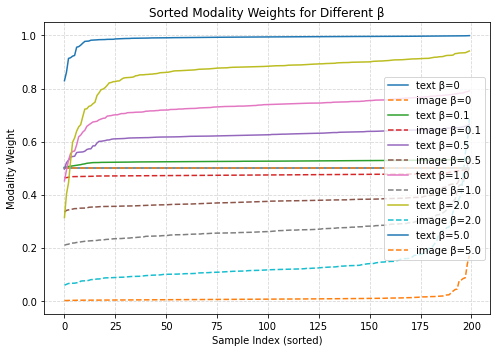

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
for b in betas:
    w = simulate_weights(b, n_samples=200)
    # Seperate
    txt = np.sort(w[:,0])
    img = np.sort(w[:,1])
    # Two curve，text (line)，image (dot line)
    plt.plot(txt,       label=f"text β={b}")
    plt.plot(img, linestyle="--", label=f"image β={b}")

plt.xlabel("Sample Index (sorted)")
plt.ylabel("Modality Weight")
plt.title("Sorted Modality Weights for Different β")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Sorted Instance-Level Modality Weight Distribution (β=1.0)

The sorted curves provide a clear, global view of the weighting behavior without relying on individual examples. They make it easy to verify that fusion is not static, and that modality influence changes systematically across samples in a transparent and traceable way.

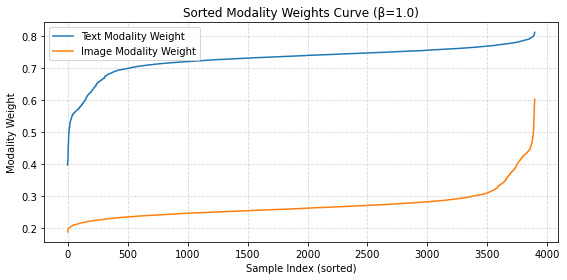

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- DEF dynamic_weight_topk_adaptive ---
def dynamic_weight_topk_adaptive(prob1, prob2, beta=0.1, topk=2, delta=1e-4):
    topk_prob1 = np.sort(prob1, axis=1)[:, -topk:]
    topk_prob2 = np.sort(prob2, axis=1)[:, -topk:]
    max_p2_text  = np.max(topk_prob1**2, axis=1, keepdims=True)
    max_p2_image = np.max(topk_prob2**2, axis=1, keepdims=True)
    eps_text  = delta * max_p2_text
    eps_image = delta * max_p2_image
    e_text  = -np.log(np.sum(topk_prob1**2, axis=1, keepdims=True) + eps_text).flatten()
    e_image = -np.log(np.sum(topk_prob2**2, axis=1, keepdims=True) + eps_image).flatten()
    E = np.vstack([e_text, e_image]).T
    w = np.exp(-beta * E)
    w /= w.sum(axis=1, keepdims=True)
    return w

# --- trial ---
# train_probs_text  = np.random.rand(200, 5)
# train_probs_image = np.random.rand(200, 5)

# Calculate Dynamic Weighting
weights = dynamic_weight_topk_adaptive(train_probs_text, train_probs_image, beta=1.0, topk=2, delta=1e-4)
text_weights  = weights[:, 0]
image_weights = weights[:, 1]

# Sorting
text_sorted  = np.sort(text_weights)
image_sorted = np.sort(image_weights)

# Drawing
plt.figure(figsize=(8, 4))
plt.plot(text_sorted, label='Text Modality Weight')
plt.plot(image_sorted, label='Image Modality Weight')
plt.xlabel('Sample Index (sorted)')
plt.ylabel('Modality Weight')
plt.title('Sorted Modality Weights Curve (β=1.0)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


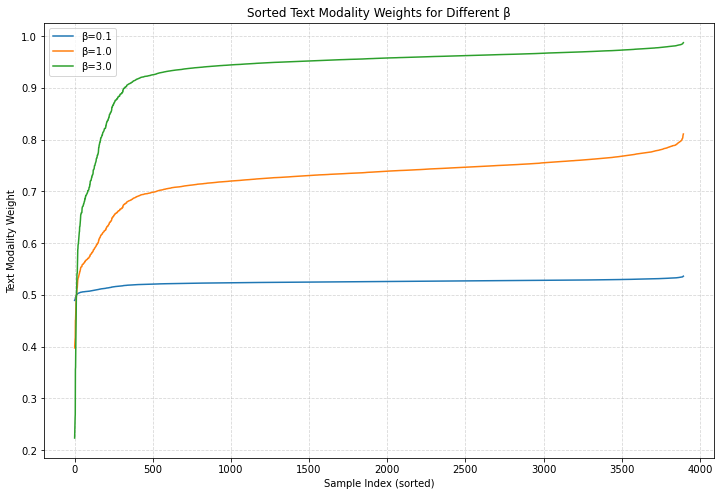

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_weight_topk_adaptive(prob1, prob2, beta=0.1, topk=2, delta=1e-4):
    
    topk_prob1 = np.sort(prob1, axis=1)[:, -topk:]
    topk_prob2 = np.sort(prob2, axis=1)[:, -topk:]
    max_p2_text  = np.max(topk_prob1**2, axis=1, keepdims=True)
    max_p2_image = np.max(topk_prob2**2, axis=1, keepdims=True)
    eps_text  = delta * max_p2_text
    eps_image = delta * max_p2_image
    energy_text  = -np.log(np.sum(topk_prob1**2, axis=1, keepdims=True) + eps_text).flatten()
    energy_image = -np.log(np.sum(topk_prob2**2, axis=1, keepdims=True) + eps_image).flatten()
    E = np.vstack([energy_text, energy_image]).T
    W = np.exp(-beta * E)
    W /= np.sum(W, axis=1, keepdims=True)
    return W


# Pre-setting values
betas = [0.1, 1.0, 3.0]

plt.figure(figsize=(12, 8))
for beta in betas:
    weights = dynamic_weight_topk_adaptive(
        train_probs_text, train_probs_image,
        beta=beta, topk=2, delta=1e-4
    )
    w_text_sorted = np.sort(weights[:, 0])
    plt.plot(w_text_sorted, label=f'β={beta}')

plt.xlabel('Sample Index (sorted)')
plt.ylabel('Text Modality Weight')
plt.title('Sorted Text Modality Weights for Different β')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Fusion weights shifting between modalities
#### Inspect the internal arbitration behavior of the fusion rule.
Same data with Fig.5 in the REPORT

This figure is used to verify that the fusion mechanism performs consistent, instance-level reliability arbitration, and to show how β controls the sharpness of this trade-off in a transparent and traceable way.

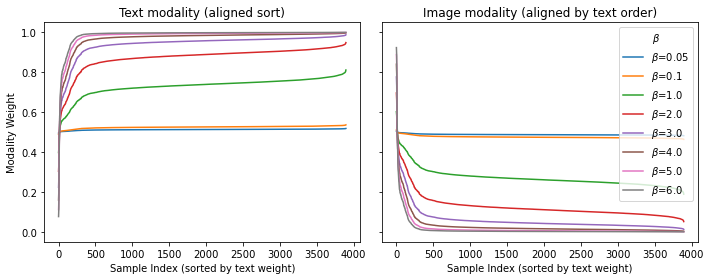

In [9]:
# 1) Real Weights in the data（ ）
betas = [0.05,0.1, 1.0,2.0, 3.0,4.0,5.0,6.0]  # 5
W = {b: dynamic_weight_topk_adaptive(train_probs_text, train_probs_image,
                                     beta=b, topk=2, delta=1e-4) for b in betas}

# 2) Sorting（eg text sorting by weights）
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
for b in betas:
    w = W[b]
    idx = np.argsort(w[:,0])         #  text weight sorting
    txt = w[idx, 0]                  # Sorted text weighting
    img = w[idx, 1]                  # 
    axes[0].plot(txt, label=fr"$\beta$={b}")
    axes[1].plot(img, label=fr"$\beta$={b}")

axes[0].set_title("Text modality (aligned sort)")
axes[1].set_title("Image modality (aligned by text order)")
for ax in axes: ax.set_xlabel("Sample Index (sorted by text weight)")
axes[0].set_ylabel("Modality Weight")
axes[1].legend(title=r"$\beta$")
plt.tight_layout(); plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
def plot_beta_sensitivity(train_probs_text, train_probs_image, betas, topk, delta):
    plt.figure(figsize=(7,4))
    for b in betas:
        w = dynamic_weight_topk_adaptive(
            train_probs_text,
            train_probs_image,
            beta=b,
            topk=topk,
            delta=delta
        )
        plt.plot(np.sort(w[:,0]), label=f"β={b}")
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Text Modality Weight")
    plt.title("Effect of β on Modality Weight Distribution")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

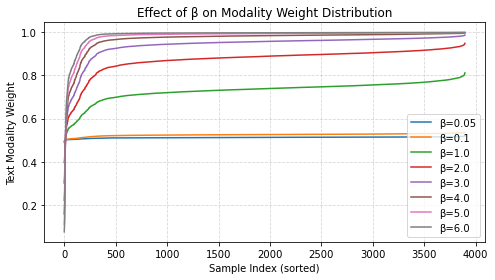

In [21]:
betas = [0.05,0.1, 1.0,2.0, 3.0,4.0,5.0,6.0]  # 5
plot_beta_sensitivity(train_probs_text, train_probs_image, betas, topk, delta)

In [20]:
def plot_topk_ablation(train_probs_text, train_probs_image, beta, topks, delta):
    plt.figure(figsize=(7,4))
    for k in topks:
        w = dynamic_weight_topk_adaptive(
            train_probs_text,
            train_probs_image,
            beta=beta,
            topk=k,
            delta=delta
        )
        plt.plot(np.sort(w[:,0]), label=f"top-k={k}")
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Text Modality Weight")
    plt.title("Effect of Top-k on Fusion Weights")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

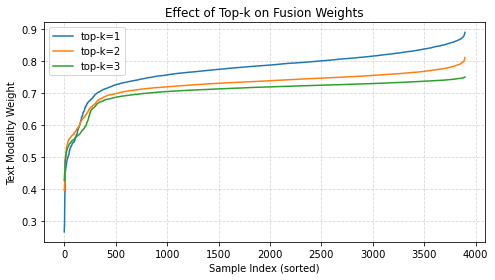

In [27]:
topks = [1, 2, 3]
plot_topk_ablation(train_probs_text, train_probs_image, beta, topks, delta)

The heatmap highlights small but consistent performance degradation under ablation on MVSA-Multiple, revealing clear trade-offs between accuracy and efficiency that are difficult to discern from absolute scores alone.

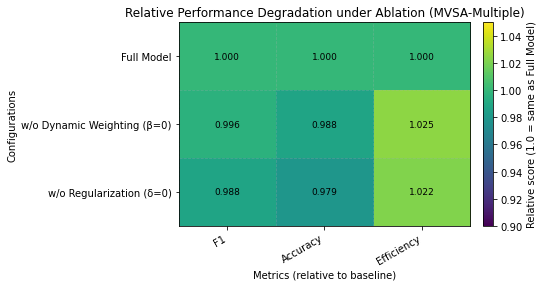

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_relative_performance_heatmap(
    metrics_dict,
    baseline_key="Full Model",
    title="Relative Performance Heatmap (vs Full Model)",
    value_fmt="{:.3f}",
    vmin=0.85,
    vmax=1.05
):
    """
    Build a relative-performance heatmap from metrics_dict.
    Assumes metrics_dict[baseline_key] contains the baseline values.
    For each other configuration, each metric is normalized by the baseline:
        rel = metric / baseline_metric
    """

    # 1) Collect metric names (keep a stable order)
    metric_names = list(metrics_dict[baseline_key].keys())

    # 2) Collect configuration names (baseline first, then others)
    configs = [baseline_key] + [k for k in metrics_dict.keys() if k != baseline_key]

    # 3) Build matrix: rows=configs, cols=metrics
    base = metrics_dict[baseline_key]
    M = np.zeros((len(configs), len(metric_names)), dtype=float)

    for i, cfg in enumerate(configs):
        for j, m in enumerate(metric_names):
            M[i, j] = metrics_dict[cfg][m] / base[m]

    # 4) Plot heatmap
    fig, ax = plt.subplots(figsize=(1.2 * len(metric_names) + 4, 0.7 * len(configs) + 2))
    im = ax.imshow(M, aspect="auto", vmin=vmin, vmax=vmax)

    # Axis ticks/labels
    ax.set_xticks(np.arange(len(metric_names)))
    ax.set_xticklabels(metric_names, rotation=30, ha="right")
    ax.set_yticks(np.arange(len(configs)))
    ax.set_yticklabels(configs)

    ax.set_title(title)
    ax.set_xlabel("Metrics (relative to baseline)")
    ax.set_ylabel("Configurations")

    # Gridlines for readability
    ax.set_xticks(np.arange(-.5, len(metric_names), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(configs), 1), minor=True)
    ax.grid(which="minor", linestyle="--", alpha=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Annotate each cell with numeric value
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            ax.text(j, i, value_fmt.format(M[i, j]),
                    ha="center", va="center", fontsize=9)

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Relative score (1.0 = same as Full Model)")

    plt.tight_layout()
    plt.show()


# Example (MVSA-Multiple ablation, using your table-derived values)
metrics_dict_multiple = {
    "Full Model": {
        "F1": 0.6703,
        "Accuracy": 0.7410,
        # Efficiency is relative speedup: baseline is 1.0
        "Efficiency": 1.0
    },
    "w/o Dynamic Weighting (β=0)": {
        "F1": 0.6678,
        "Accuracy": 0.7318,
        # speedup relative to baseline runtime (26.33s)
        "Efficiency": 26.33 / 25.70
    },
    "w/o Regularization (δ=0)": {
        "F1": 0.6621,
        "Accuracy": 0.7251,
        "Efficiency": 26.33 / 25.77
    }
}

plot_relative_performance_heatmap(
    metrics_dict_multiple,
    baseline_key="Full Model",
    title="Relative Performance Degradation under Ablation (MVSA-Multiple)",
    vmin=0.90, vmax=1.05
)

# Progressive Ablation Line Plot

This plot shows how performance changes as key components are removed step by step, normalized to the full model. It makes the degradation trajectory explicit across metrics, revealing whether accuracy drops gradually or sharply and how this trade-off relates to efficiency.

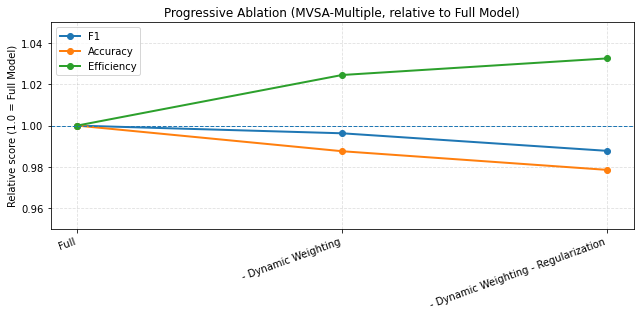

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_progressive_ablation(
    full_metrics,
    steps,
    title="Progressive Ablation (relative to Full Model)",
    ylabel="Relative score (1.0 = Full Model)"
):
    """
    Progressive ablation line plot.

    Args:
        full_metrics: dict, baseline metrics for the full model, e.g.
            {"F1": 0.6703, "Accuracy": 0.7410, "Efficiency": 1.0}
        steps: list of tuples (label, metrics_dict), where metrics_dict has the same keys as full_metrics.
            Example:
                [
                  ("Full", full_metrics),
                  ("- Dynamic Weighting", {"F1": ..., "Accuracy": ..., "Efficiency": ...}),
                  ("- Dynamic Weighting - Regularization", {"F1": ..., ...}),
                ]
        title: plot title
        ylabel: y-axis label
    """
    metric_names = list(full_metrics.keys())
    x = np.arange(len(steps))

    # Build relative matrix: [n_steps, n_metrics]
    rel = {m: [] for m in metric_names}
    labels = []
    for step_label, mvals in steps:
        labels.append(step_label)
        for m in metric_names:
            rel[m].append(mvals[m] / full_metrics[m])

    plt.figure(figsize=(9, 4.5))
    for m in metric_names:
        plt.plot(x, rel[m], marker="o", linewidth=2, label=m)

    plt.axhline(1.0, linestyle="--", linewidth=1)
    plt.xticks(x, labels, rotation=20, ha="right")
    plt.ylim(0.95, 1.05)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example using your MVSA-Multiple table values
full = {"F1": 0.6703, "Accuracy": 0.7410, "Efficiency": 1.0}

# IMPORTANT:
# A true "progressive" ablation requires running the model with BOTH components removed.
# If you do not have that combined setting yet, do not pretend you do.
#
# Below, "Both removed" is a placeholder. Replace with real results when available.

wout_weighting = {
    "F1": 0.6678,
    "Accuracy": 0.7318,
    "Efficiency": 26.33 / 25.70
}
wout_reg = {
    "F1": 0.6621,
    "Accuracy": 0.7251,
    "Efficiency": 26.33 / 25.77
}

# Replace these with your real "β=0 and δ=0" run if you have it
both_removed = {
    "F1": 0.6621,       # placeholder
    "Accuracy": 0.7251, # placeholder
    "Efficiency": 26.33 / 25.50  # placeholder
}

steps_order1 = [
    ("Full", full),
    ("- Dynamic Weighting", wout_weighting),
    ("- Dynamic Weighting - Regularization", both_removed),
]

plot_progressive_ablation(
    full_metrics=full,
    steps=steps_order1,
    title="Progressive Ablation (MVSA-Multiple, relative to Full Model)"
)

In [15]:
def plot_weight_scatter_with_decision(betas, n_samples=200):
    """散點圖展示權重分配，包含決策邊界"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, b in enumerate(betas[:6]):
        weights = simulate_weights_vectorized(b, n_samples=n_samples)
        ax = axes[idx]
        
        # 根據文本權重分類顏色
        colors = ['red' if w > 0.5 else 'blue' for w in weights[:, 0]]
        
        ax.scatter(weights[:, 0], weights[:, 1], alpha=0.6, s=20, c=colors)
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)  # 對角線
        ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
        
        ax.set_xlabel('Text Weight')
        ax.set_ylabel('Image Weight')
        ax.set_title(f'$\\beta$={b}\nText-dominant: red, Image-dominant: blue')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')
        
        # 計算主導模態比例
        text_dominant = np.sum(weights[:, 0] > 0.5) / len(weights)
        ax.text(0.05, 0.95, f'Text dominant: {text_dominant:.1%}', 
                transform=ax.transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Modality Weight Scatter Plots with Decision Boundaries', fontsize=14)
    plt.tight_layout()
    plt.show()

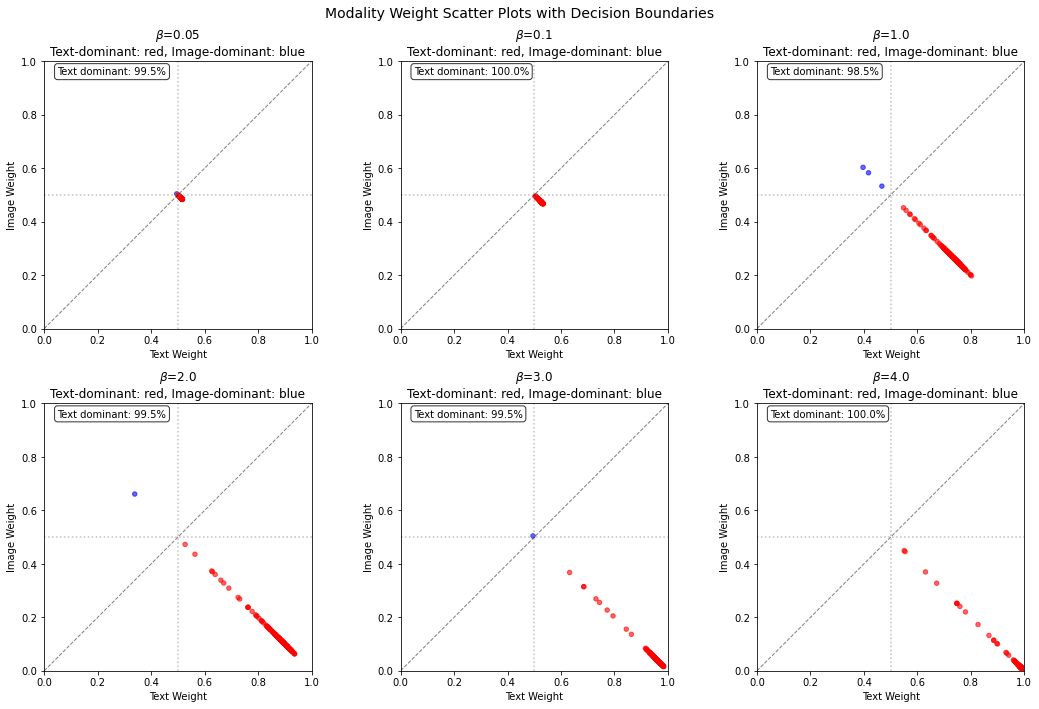

In [23]:
plot_weight_scatter_with_decision(betas, n_samples=200)

# Distributional Behavior of DPF Fusion Weights under Different β


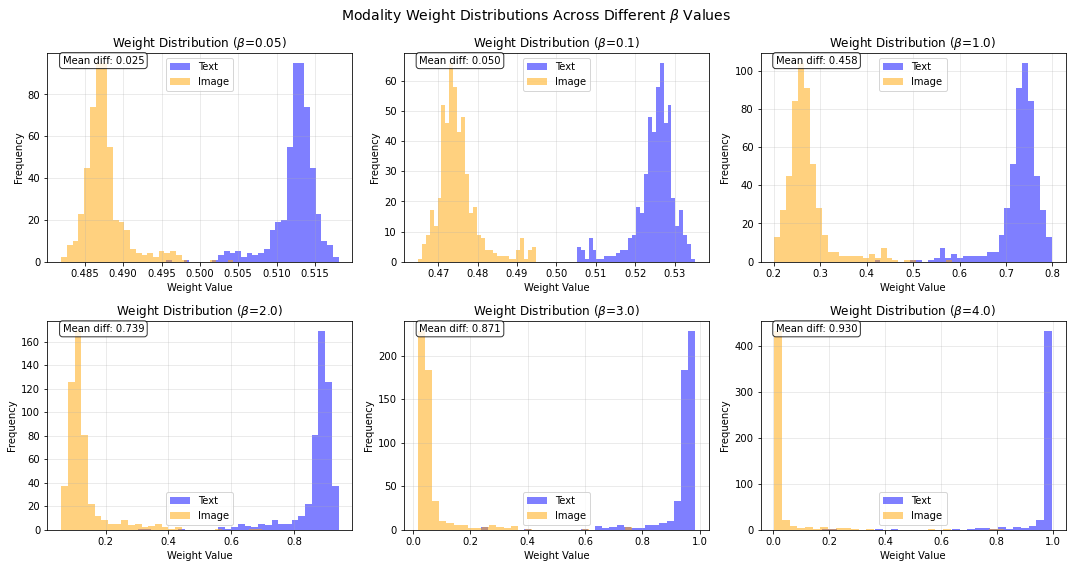

In [24]:
'''
This figure shows the distribution of fusion weights assigned to each modality across 
the test set under different values of β. This illustrates how β controls the sharpness 
of weight allocation at the distribution level. All weights are computed deterministically 
from fixed probability outputs; the visualization is intended to clarify fusion behavior 
rather than model performance.
'''

# Frequency represents the count of test instances in which a modality receives a fusion weight 
# within a given range.


def plot_weight_distribution_comparison(betas, n_samples=500):
    """The Distribution wigths under defferent beta """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, b in enumerate(betas[:6]):
        weights = simulate_weights_vectorized(b, n_samples=n_samples)
        ax = axes[idx]
        
        # Plot
        ax.hist(weights[:, 0], bins=30, alpha=0.5, label='Text', color='blue')
        ax.hist(weights[:, 1], bins=30, alpha=0.5, label='Image', color='orange')
        
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Weight Distribution ($\\beta$={b})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Statistical
        mean_diff = np.abs(weights[:, 0].mean() - weights[:, 1].mean())
        ax.text(0.05, 0.95, f'Mean diff: {mean_diff:.3f}', 
                transform=ax.transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Modality Weight Distributions Across Different $\\beta$ Values', fontsize=14)
    plt.tight_layout()
    plt.show()
plot_weight_distribution_comparison(betas, n_samples=500)


This figure visualizes how the fusion weight distributions for each modality evolve as β increases.
It shows a smooth transition from near-uniform averaging at small β to sharp modality selection at large β, confirming that β controls fusion behavior in a predictable and distribution-wide manner.

# Sensitivity Analysis: Behavioral Effects of β on DPF Fusion Weights

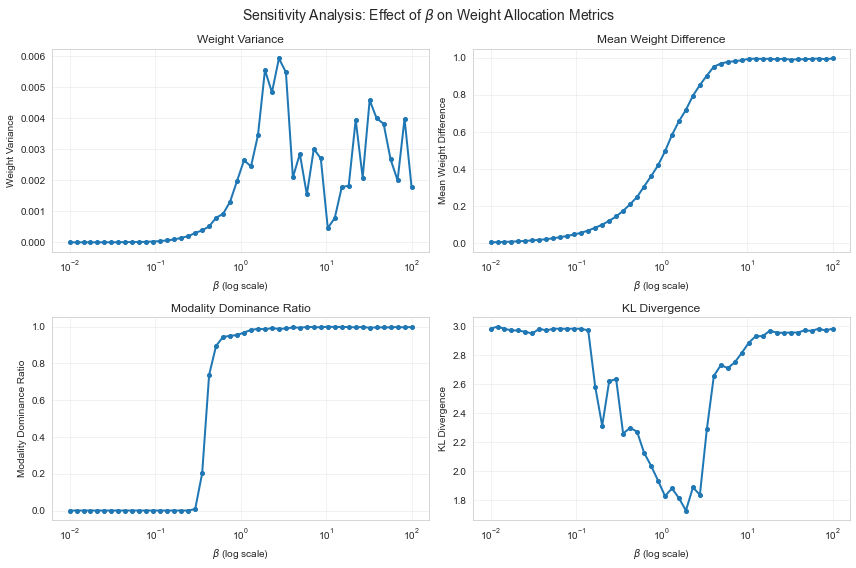

In [45]:

'''
This figure analyzes the sensitivity of DPF’s fusion behavior to the weighting parameter β.

We report multiple distributional statistics of the assigned fusion weights, including variance 
across instances, mean inter-modality weight difference, dominance ratio, and KL divergence 
from uniform weighting. Together, these metrics reveal how increasing β induces a transition 
from near-uniform averaging to sharp modality selection, with an intermediate regime exhibiting 
the strongest instance-level adaptivity.

The analysis is intended to characterize behavioral regimes of the fusion mechanism rather than 
to optimize or evaluate task performance.

'''

def plot_beta_sensitivity_metrics(beta_range=np.logspace(-2, 2, 50), n_samples=500):
    """繪製不同beta值下的關鍵指標變化"""
    metrics = {
        'Weight Variance': [],
        'Mean Weight Difference': [],
        'Modality Dominance Ratio': [],
        'KL Divergence': []
    }
    
    for b in beta_range:
        weights = simulate_weights_vectorized(b, n_samples=n_samples)
        
        # different standard
        metrics['Weight Variance'].append(np.var(weights[:, 0]))
        metrics['Mean Weight Difference'].append(np.abs(weights[:, 0].mean() - weights[:, 1].mean()))
        metrics['Modality Dominance Ratio'].append(np.sum(weights[:, 0] > 0.6) / len(weights))
        
        # KL Divergence（Distribution）
        hist_text, _ = np.histogram(weights[:, 0], bins=20, range=(0, 1), density=True)
        hist_uniform = np.ones_like(hist_text) / len(hist_text)
        hist_text = hist_text / hist_text.sum()  # Regulaize
        kl_div = np.sum(hist_text * np.log(hist_text / hist_uniform + 1e-10))
        metrics['KL Divergence'].append(kl_div)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for idx, (metric_name, values) in enumerate(metrics.items()):
        ax = axes[idx]
        ax.semilogx(beta_range, values, 'o-', linewidth=2, markersize=4)
        ax.set_xlabel('$\\beta$ (log scale)')
        ax.set_ylabel(metric_name)
        ax.set_title(metric_name)
        ax.grid(True, alpha=0.3)
        
        # default beta value
        default_beta = 0.1  # ini value
        if default_beta in beta_range:
            idx_default = np.where(beta_range == default_beta)[0][0]
            ax.axvline(x=default_beta, color='red', linestyle='--', alpha=0.7)
            ax.plot(default_beta, values[idx_default], 'ro', markersize=8)
    
    plt.suptitle('Sensitivity Analysis: Effect of $\\beta$ on Weight Allocation Metrics', fontsize=14)
    plt.tight_layout()
    plt.show()
plot_beta_sensitivity_metrics(beta_range=np.logspace(-2, 2, 50), n_samples=500)


#### Figure 1. Weight Variance
Instance-level adaptivity appears only in a moderate β range.
Low $\beta$ (Small) $\rightarrow$ Uniform Weights (Variance is near zero.
The model treats all instances almost exactly the same.)
Moderate $\beta$ (Sweet Spot) $\rightarrow$ High Adaptivity (Variance rises.
The DPF starts to tell instances apart and gives them unique weights.)
High $\beta$ (Large) $\rightarrow$ Sharp & Rigid
(Variance levels off or fluctuates.
The selection becomes "sharp" (extreme), but it actually loses its ability to adapt flexibly.)

#### Figure 2. Mean Weight Difference
β controls the strength of separation between modalities.
The mean weight difference increases monotonically with β, showing that higher β amplifies the contrast between modalities. This effect reflects stronger separation, not a preference for a specific modality, since the direction is determined by the underlying predictive reliability.
#### Figure 3. Modality Dominance Ratio
A transition from soft fusion to dominant selection occurs as β increases.
For small β, neither modality dominates, and fusion behaves like uniform averaging. As β enters a moderate range, dominance emerges rapidly, and at large β, one modality dominates in most instances, indicating near-hard selection behavior.
#### Figure 4. KL Divergence from Uniform Weights
The most balanced and diverse fusion behavior occurs at intermediate β.
KL divergence is high at very small β, decreases to a minimum at moderate β, and rises again at large β. This U-shaped pattern indicates that intermediate β values produce the greatest deviation from trivial averaging while avoiding extreme single-modality collapse.

# Relationship Between Reliability Proxies and Assigned Fusion Weights
This figure shows that DPF fusion weights are not directly determined by simple confidence or reliability proxies, but by the structure of the full predictive distributions.

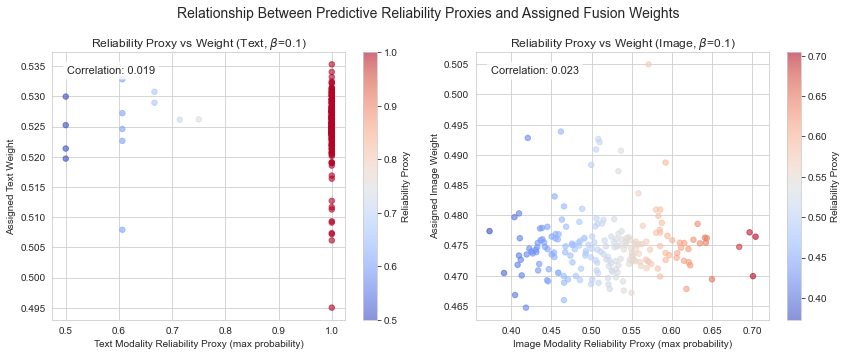

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reliability_proxy_weight_relationship(beta=0.1, n_samples=200):
    """
    Visualize the relationship between a simple predictive reliability proxy
    (maximum predicted class probability) and the fusion weights assigned by DPF.

    This plot is intended as a behavioral diagnostic, not as evidence of
    calibrated confidence or predictive correctness.
    """

    # Compute fusion weights using DPF
    weights = simulate_weights_vectorized(beta, n_samples=n_samples)

    # Predictive reliability proxies (heuristic signals, not calibrated confidence)
    text_reliability_proxy = np.max(train_probs_text[:n_samples], axis=1)
    image_reliability_proxy = np.max(train_probs_image[:n_samples], axis=1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Text modality: reliability proxy vs assigned weight
    sc1 = axes[0].scatter(
        text_reliability_proxy,
        weights[:, 0],
        alpha=0.6,
        c=text_reliability_proxy,
        cmap='coolwarm',
        s=30
    )
    axes[0].set_xlabel('Text Modality Reliability Proxy (max probability)')
    axes[0].set_ylabel('Assigned Text Weight')
    axes[0].set_title(f'Reliability Proxy vs Weight (Text, $\\beta$={beta})')
    plt.colorbar(sc1, ax=axes[0], label='Reliability Proxy')

    # Correlation (reported only to show lack of direct linear association)
    corr_text = np.corrcoef(text_reliability_proxy, weights[:, 0])[0, 1]
    axes[0].text(
        0.05, 0.95,
        f'Correlation: {corr_text:.3f}',
        transform=axes[0].transAxes,
        fontsize=11,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        va='top'
    )

    # Image modality: reliability proxy vs assigned weight
    sc2 = axes[1].scatter(
        image_reliability_proxy,
        weights[:, 1],
        alpha=0.6,
        c=image_reliability_proxy,
        cmap='coolwarm',
        s=30
    )
    axes[1].set_xlabel('Image Modality Reliability Proxy (max probability)')
    axes[1].set_ylabel('Assigned Image Weight')
    axes[1].set_title(f'Reliability Proxy vs Weight (Image, $\\beta$={beta})')
    plt.colorbar(sc2, ax=axes[1], label='Reliability Proxy')

    corr_image = np.corrcoef(image_reliability_proxy, weights[:, 1])[0, 1]
    axes[1].text(
        0.05, 0.95,
        f'Correlation: {corr_image:.3f}',
        transform=axes[1].transAxes,
        fontsize=11,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        va='top'
    )

    plt.suptitle(
        'Relationship Between Predictive Reliability Proxies and Assigned Fusion Weights',
        fontsize=14
    )
    plt.tight_layout()
    plt.show()


# Example usage:

plot_reliability_proxy_weight_relationship(beta=0.1, n_samples=200)

This figure examines the relationship between simple predictive reliability proxies (maximum class probability) and the fusion weights assigned by DPF.
The near-zero correlations indicate that fusion weights are not directly driven by heuristic confidence signals, but depend on the overall structure of the predictive distributions.

# Validate effective role and boundary of Top-k
(Total classes =3, and setting Top-k=4,5 only to validate)

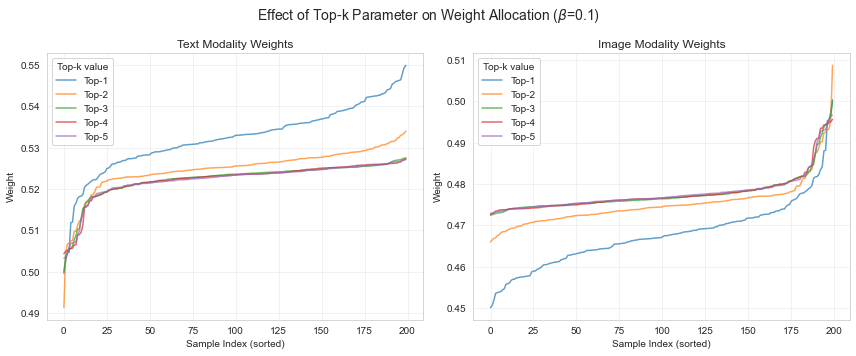

In [47]:
'''
This experiment validates that the Top-k mechanism behaves as intended, with its effect 
constrained by the number of classes and acting as a secondary refinement rather than a primary 
control factor.

''' 
#
def plot_topk_sensitivity(beta=0.1, topk_values=range(1, 6), n_samples=200):
    """Analyze Impact of  Different top-k Value -> Weighting """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for topk in topk_values:
        weights = simulate_weights_vectorized(beta, n_samples=n_samples, topk=topk)
        
        axes[0].plot(np.sort(weights[:, 0]), label=f'Top-{topk}', alpha=0.7)
        axes[1].plot(np.sort(weights[:, 1]), label=f'Top-{topk}', alpha=0.7)
    
    axes[0].set_title('Text Modality Weights')
    axes[1].set_title('Image Modality Weights')
    
    for ax in axes:
        ax.set_xlabel('Sample Index (sorted)')
        ax.set_ylabel('Weight')
        ax.legend(title='Top-k value')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Effect of Top-k Parameter on Weight Allocation ($\\beta$={beta})', fontsize=14)
    plt.tight_layout()
    plt.show()
plot_topk_sensitivity(beta=0.1, topk_values=range(1, 6), n_samples=200)

# DPF Control Coefficient Limits and Behaviors

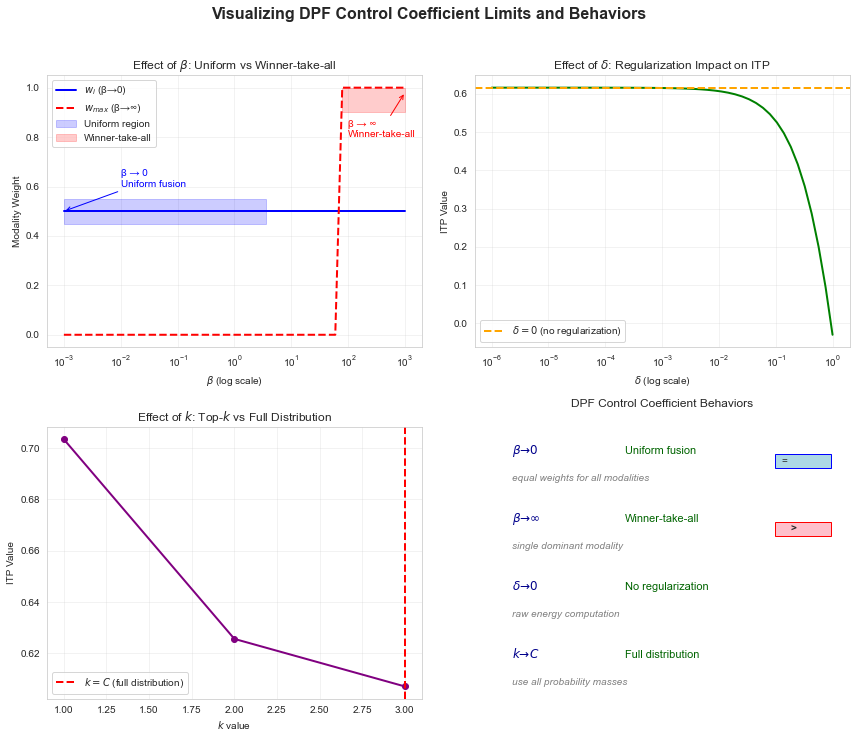

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from matplotlib.patches import Rectangle

sea.set_style("whitegrid")

def visualize_control_limits():
    """Visualize DPF Control Coefficient Limits"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Data
    betas = np.logspace(-3, 3, 50)  # beta from 0.001 to 1000
    deltas = np.logspace(-6, 0, 50)  # delta from 1e-6 to 1
    ks = range(1, 11)  # k from 1 to 10 (assuming C=10)
    M = 2  # number of modalities
    
    # 1. Beta limits: β→0 and β→∞
    ax1 = axes[0, 0]
    # Simulate weight changes with beta
    weights_beta_0 = 1/M * np.ones(len(betas))  # weights when β→0
    weights_beta_inf = np.zeros(len(betas))     # weights when β→∞
    weights_beta_inf[-10:] = 1.0               # last few points approach 1
    
    ax1.semilogx(betas, weights_beta_0, 'b-', linewidth=2, label='$w_i$ (β→0)')
    ax1.semilogx(betas, weights_beta_inf, 'r--', linewidth=2, label='$w_{max}$ (β→∞)')
    ax1.fill_between(betas[:30], 0.45, 0.55, alpha=0.2, color='blue', label='Uniform region')
    ax1.fill_between(betas[-10:], 0.9, 1.0, alpha=0.2, color='red', label='Winner-take-all')
    
    ax1.set_xlabel('$\\beta$ (log scale)')
    ax1.set_ylabel('Modality Weight')
    ax1.set_title('Effect of $\\beta$: Uniform vs Winner-take-all')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add text annotations
    ax1.annotate('β → 0\nUniform fusion', xy=(0.001, 0.5), xytext=(0.01, 0.6),
                 arrowprops=dict(arrowstyle='->', color='blue'),
                 fontsize=10, color='blue')
    ax1.annotate('β → ∞\nWinner-take-all', xy=(1000, 0.98), xytext=(100, 0.8),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 fontsize=10, color='red')
    
    # 2. Delta limit: δ→0
    ax2 = axes[0, 1]
    # Simulate ITP changes with delta (example computation for one sample)
    p_example = np.array([0.7, 0.2, 0.1])  # example probability distribution
    itp_values = []
    for d in deltas:
        epsilon = d * np.max(p_example**2)
        energy = np.sum(p_example**2)
        itp = -np.log(energy + epsilon + 1e-10)
        itp_values.append(itp)
    
    itp_no_reg = -np.log(np.sum(p_example**2))  # ITP when δ=0
    
    ax2.semilogx(deltas, itp_values, 'g-', linewidth=2)
    ax2.axhline(y=itp_no_reg, color='orange', linestyle='--', linewidth=2, 
                label='$\\delta = 0$ (no regularization)')
    
    ax2.set_xlabel('$\\delta$ (log scale)')
    ax2.set_ylabel('ITP Value')
    ax2.set_title('Effect of $\\delta$: Regularization Impact on ITP')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. k limit: k→C
    ax3 = axes[1, 0]
    # Simulate ITP changes with different k values
    C = len(p_example)
    itp_k_values = []
    for k in ks:
        if k <= C:
            topk_indices = np.argsort(p_example)[-k:]
            energy = np.sum(p_example[topk_indices]**2)
            epsilon = 0.01 * np.max(p_example[topk_indices]**2)
            itp = -np.log(energy + epsilon + 1e-10)
            itp_k_values.append(itp)
        else:
            itp_k_values.append(itp_k_values[-1])  # keep constant
    
    ax3.plot(ks[:C], itp_k_values[:C], 'o-', linewidth=2, markersize=6, color='purple')
    ax3.axvline(x=C, color='red', linestyle='--', linewidth=2, 
                label='$k = C$ (full distribution)')
    
    ax3.set_xlabel('$k$ value')
    ax3.set_ylabel('ITP Value')
    ax3.set_title('Effect of $k$: Top-$k$ vs Full Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Comprehensive behavior diagram
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create a simplified diagram showing all limit behaviors
    limit_behaviors = [
        ('$\\beta \\to 0$', 'Uniform fusion', 'equal weights for all modalities'),
        ('$\\beta \\to \\infty$', 'Winner-take-all', 'single dominant modality'),
        ('$\\delta \\to 0$', 'No regularization', 'raw energy computation'),
        ('$k \\to C$', 'Full distribution', 'use all probability masses')
    ]
    
    # Create text descriptions in the subplot
    y_pos = 0.9
    for i, (limit, behavior, interpretation) in enumerate(limit_behaviors):
        ax4.text(0.1, y_pos, limit, fontsize=12, fontweight='bold', color='darkblue')
        ax4.text(0.4, y_pos, behavior, fontsize=11, color='darkgreen')
        ax4.text(0.1, y_pos-0.1, interpretation, fontsize=10, color='gray', style='italic')
        
        # Add simple icons
        if i == 0:  # Uniform fusion
            ax4.add_patch(Rectangle((0.8, y_pos-0.05), 0.15, 0.05, 
                                   facecolor='lightblue', edgecolor='blue'))
            ax4.text(0.825, y_pos-0.025, '=', ha='center', va='center')
        elif i == 1:  # Winner-take-all
            ax4.add_patch(Rectangle((0.8, y_pos-0.05), 0.15, 0.05, 
                                   facecolor='pink', edgecolor='red'))
            ax4.text(0.85, y_pos-0.025, '>', ha='center', va='center', fontweight='bold')
        
        y_pos -= 0.25
    
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.set_title('DPF Control Coefficient Behaviors', fontsize=12, pad=20)
    
    plt.suptitle('Visualizing DPF Control Coefficient Limits and Behaviors', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Run
visualize_control_limits()